## Goals

The goal of the coding part of this homework assignment is to practice the process of tuning hyperparameters to find a good neural network model.

We will work with the same Reuters newswires data set from the last homework.  In that assignment, we accepted the model that Chollet used in the book.  Here we will see if we can improve that model at all.

## Module Imports

In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.datasets import reuters
import matplotlib.pyplot as plt
from scipy.special import softmax
import numpy as np
import copy

Using TensorFlow backend.


## Load data

In [2]:
(train_and_val_data, train_and_val_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train_and_val = vectorize_sequences(train_and_val_data)
x_test = vectorize_sequences(test_data)

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_and_val_labels = to_one_hot(train_and_val_labels)
one_hot_test_labels = to_one_hot(test_labels)
y_test = one_hot_test_labels

x_val = x_train_and_val[:1000]
x_train = x_train_and_val[1000:]

y_val = one_hot_train_labels[:1000]
y_train = one_hot_train_labels[1000:]

2113536/2110848 [==============================] - 1s 0us/step


## Chollet's Model
You don't have to do anything with the code below.  This is our baseline model, the one from the book.

In [0]:
chollet_model = models.Sequential()
chollet_model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
chollet_model.add(layers.Dense(64, activation='relu'))
chollet_model.add(layers.Dense(46, activation='softmax'))

In [106]:
chollet_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = chollet_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 9s 1ms/step - loss: 2.5443 - acc: 0.5405 - val_loss: 1.6874 - val_acc: 0.6520
Epoch 2/20
7982/7982 [==============================] - 0s 56us/step - loss: 1.3742 - acc: 0.7093 - val_loss: 1.2770 - val_acc: 0.7180
Epoch 3/20
7982/7982 [==============================] - 0s 61us/step - loss: 1.0264 - acc: 0.7757 - val_loss: 1.1146 - val_acc: 0.7500
Epoch 4/20
7982/7982 [==============================] - 0s 57us/step - loss: 0.8105 - acc: 0.8267 - val_loss: 1.0324 - val_acc: 0.7810
Epoch 5/20
7982/7982 [==============================] - 0s 56us/step - loss: 0.6437 - acc: 0.8613 - val_loss: 0.9676 - val_acc: 0.7920
Epoch 6/20
7982/7982 [==============================] - 0s 55us/step - loss: 0.5149 - acc: 0.8887 - val_loss: 0.9308 - val_acc: 0.8110
Epoch 7/20
7982/7982 [==============================] - 0s 55us/step - loss: 0.4186 - acc: 0.9085 - val_loss: 0.9275 - val_acc: 0.8150
Epoch 8/

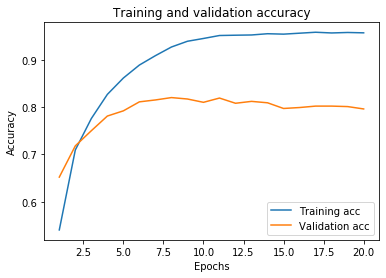

In [107]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Note that validation set accuracy of this model ended up at about 0.8.  We'll try to find a combination of hyperparameters with better validation set accuracy, and then refit both our final model and Chollet's model to the full combined training and validation set data and evaluate their performance on the test set.

In [102]:
np.random.seed(6473)
dropout_rates = np.random.uniform(low = 0.0, high = 0.5, size = (8,))
l2_penalties_exp = np.random.uniform(low = -6, high = -1, size = (8,))
num_units = np.random.uniform(low = 46, high = 128, size = (8,)).astype(int)
l2_penalties = 10**l2_penalties_exp

val_acc = np.zeros((8,))

for (i, (dropout_rate, l2_penalty, num_unit)) in enumerate(zip(dropout_rates, l2_penalties, num_units)):
  model_dropout = models.Sequential()

  model_dropout.add(layers.Dropout(rate = dropout_rate))
  model_dropout.add(layers.Dense(num_unit, activation='relu', kernel_regularizer=regularizers.l2(l = l2_penalty), input_shape=(10000,)))
  model_dropout.add(layers.Dropout(rate = dropout_rate))
  model_dropout.add(layers.Dense(num_unit, activation='relu', kernel_regularizer=regularizers.l2(l = l2_penalty)))
  model_dropout.add(layers.Dropout(rate = dropout_rate))
  model_dropout.add(layers.Dense(46, activation='softmax'))

  model_dropout.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = model_dropout.fit(partial_x_train,
                      partial_y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))
  
  val_acc[i] = history.history['val_acc'][-1]

Train on 7982 samples, validate on 1000 samples
Epoch 1/100
7982/7982 [==============================] - 9s 1ms/step - loss: 3.3158 - acc: 0.3266 - val_loss: 2.3515 - val_acc: 0.5260
Epoch 2/100
7982/7982 [==============================] - 1s 70us/step - loss: 2.1381 - acc: 0.5114 - val_loss: 1.6845 - val_acc: 0.6050
Epoch 3/100
7982/7982 [==============================] - 1s 69us/step - loss: 1.7165 - acc: 0.5981 - val_loss: 1.4768 - val_acc: 0.6710
Epoch 4/100
7982/7982 [==============================] - 1s 70us/step - loss: 1.5072 - acc: 0.6596 - val_loss: 1.3303 - val_acc: 0.7000
Epoch 5/100
7982/7982 [==============================] - 1s 71us/step - loss: 1.3415 - acc: 0.6989 - val_loss: 1.2395 - val_acc: 0.7210
Epoch 6/100
7982/7982 [==============================] - 1s 70us/step - loss: 1.2375 - acc: 0.7214 - val_loss: 1.1771 - val_acc: 0.7560
Epoch 7/100
7982/7982 [==============================] - 1s 70us/step - loss: 1.1461 - acc: 0.7497 - val_loss: 1.1216 - val_acc: 0.7610
E

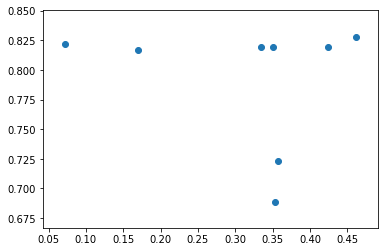

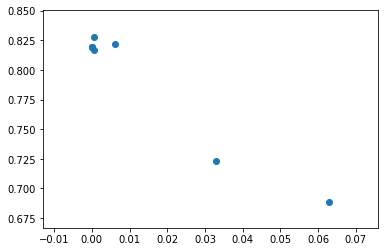

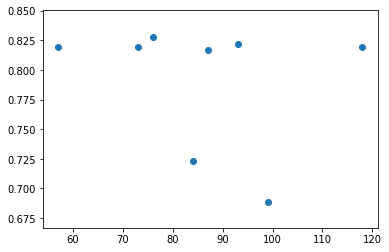

In [103]:
plt.scatter(dropout_rates[0:8], val_acc[0:8])
plt.show()
plt.scatter(l2_penalties[0:8], val_acc[0:8])
plt.show()
plt.scatter(num_units[0:8], val_acc[0:8])
plt.show()

In [4]:
np.random.seed(6473)
dropout_rates = np.random.uniform(low = 0.0, high = 0.5, size = (8,))
l2_penalties_exp = np.random.uniform(low = -6, high = -1, size = (8,))
num_layers = np.random.uniform(low = 1, high = 5, size = (8,)).astype(int)
l2_penalties = 10**l2_penalties_exp

val_acc = np.zeros((8,))

for (i, (dropout_rate, l2_penalty, num_layer)) in enumerate(zip(dropout_rates, l2_penalties, num_layers)):
  model = models.Sequential()

  model.add(layers.Dropout(rate = dropout_rate))

  for j in range(num_layer):
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l = l2_penalty), input_shape=(10000,)))
    model.add(layers.Dropout(rate = dropout_rate))
  
  model.add(layers.Dense(46, activation='softmax'))

  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  history = model.fit(partial_x_train,
                      partial_y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))
  
  val_acc[i] = history.history['val_acc'][-1]




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7982 samples, validate on 1000 samples
Epoch 1/100





7982/7982 [==============================] - 11s 1ms/step - loss: 3.4302 - acc: 0.2088 - val_loss: 2.5174 - val_acc: 0.3540
Epoch 2/100
7982/7982 [==============================] - 0s 60us/step - loss: 2.4533 - acc: 0.3723 - val_loss: 1.9940 - val_acc: 0.5240
Epoch 3/100
7982/7982 [==============================] - 0s 58us/step - loss: 2.1067 - acc: 0.4540 - val_loss: 1.7437 - val_acc: 0.5440
Epoch 4/100
7982/7982 [==============================] - 0s 58us/step - loss: 1.9125 - acc: 0.5142 - val_loss: 1.6735 - val_acc: 0.5880
Epoch 5/100
7982/7982 [==============================] - 0s 59us/step - loss: 1.8397 - acc: 0.5385 - val_loss: 1.6187 - val_acc: 0.6050
Epoch 6/100
7982/7982 [===========================

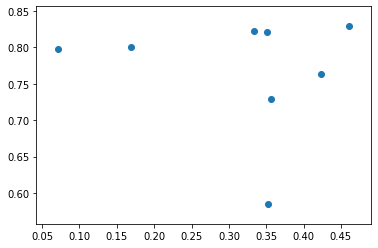

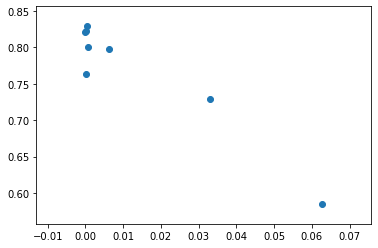

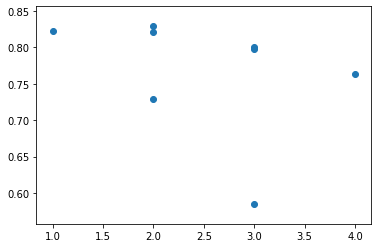

In [6]:
plt.scatter(dropout_rates[0:8], val_acc[0:8])
plt.show()
plt.scatter(l2_penalties[0:8], val_acc[0:8])
plt.show()
plt.scatter(num_layers[0:8], val_acc[0:8])
plt.show()

## Refit models to the combined training and validation set data
When we are making test set predictions, we want to do so with a model that was fit using as much data as possible.

### Chollet's Model

In [8]:
history = chollet_model.fit(x_train_and_val,
                    y_train_and_val,
                    epochs=20,
                    batch_size=512)

NameError: ignored

In [111]:
final_model = models.Sequential()

final_model.add(layers.Dropout(rate = 0.45))
final_model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
final_model.add(layers.Dropout(rate = 0.45))
final_model.add(layers.Dense(64, activation='relu'))
final_model.add(layers.Dropout(rate = 0.45))
final_model.add(layers.Dense(46, activation='softmax'))

final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = final_model.fit(x_train_and_val,
                    y_train_and_val,
                    epochs=100,
                    batch_size=512)

Train on 7982 samples, validate on 1000 samples
Epoch 1/100
7982/7982 [==============================] - 9s 1ms/step - loss: 3.2783 - acc: 0.3582 - val_loss: 2.4726 - val_acc: 0.5140
Epoch 2/100
7982/7982 [==============================] - 1s 64us/step - loss: 2.1864 - acc: 0.4977 - val_loss: 1.7071 - val_acc: 0.5990
Epoch 3/100
7982/7982 [==============================] - 1s 64us/step - loss: 1.7090 - acc: 0.6050 - val_loss: 1.4593 - val_acc: 0.6710
Epoch 4/100
7982/7982 [==============================] - 1s 64us/step - loss: 1.4711 - acc: 0.6646 - val_loss: 1.3192 - val_acc: 0.7050
Epoch 5/100
7982/7982 [==============================] - 0s 61us/step - loss: 1.3203 - acc: 0.6917 - val_loss: 1.2166 - val_acc: 0.7220
Epoch 6/100
7982/7982 [==============================] - 0s 62us/step - loss: 1.1977 - acc: 0.7172 - val_loss: 1.1405 - val_acc: 0.7400
Epoch 7/100
7982/7982 [==============================] - 1s 63us/step - loss: 1.0911 - acc: 0.7392 - val_loss: 1.0815 - val_acc: 0.7610
E

In [112]:
print(chollet_model.evaluate(x_test, y_test))
print(final_model.evaluate(x_test, y_test))

2246/2246 [==============================] - 0s 113us/step
[1.2420880563112635, 0.7760463045944832]
2246/2246 [==============================] - 0s 107us/step
[1.4232519968003963, 0.8023152271234235]
